In [21]:
from functools import lru_cache
import gmpy2
from gmpy2 import mpz

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [2]:
# terrible O(2^n) solution. Will hang "forever" on n > 100.
def naive_fib(n):
    if n < 2:
        return n
    else:
        return naive_fib(n-1) + naive_fib(n-2)

In [3]:
# dynamic programming 1: memoized version of naive algorithm
@lru_cache(100)
def memoized_fib(n):
    if n < 2:
        return n
    else:
        return memoized_fib(n-1) + memoized_fib(n-2)

In [4]:
# dynamic programming 2: bottoms-up table version of naive algorithm
def table_fib(n):
    if n < 2:
        return n
    table = [-1] * (n+1)
    table[0] = 0
    table[1] = 1
    for i in range(2, n+1):
        table[i] = table[i-1] + table[i-2]
    return table[n]

In [5]:
# dynamic programming 3: bottoms-up table version of naive algorithm
# (with finite lookback window.)
def iterative_fib(n):
    if n < 2:
        return n
    previous, current = (1, 1)
    for i in range(3, n+1):
        previous, current = (current, previous + current)
    return current

In [6]:
# simplest possible matrix based solution.
# good asymptotic performance with a poor constant.
def matrix_multiply(A, B):
    a, b, c, d = A
    x, y, z, w = B
    
    return (
        a*x + b*z,
        a*y + b*w,
        c*x + d*z,
        c*y + d*w,
    )

def naive_matrix_power(A, m):
    if m == 0:
        return [1, 0, 0, 1]
    B = A
    for _ in range(m-1):
        B = matrix_multiply(B, A)
    return B

def naive_matrix_fib(n):
    return naive_matrix_power(F1, n)[1]

def matrix_power(A, m):
    if m == 0:
        return [1, 0, 0, 1]
    elif m == 1:
        return A
    else:
        B = A
        n = 2
        while n <= m:
            # repeated square B until n = 2^q > m
            B = matrix_multiply(B, B)
            n = n*2
        # add on the remainder
        R = matrix_power(A, m-n//2)
        return matrix_multiply(B, R)

F1 = [1, 1, 
      1, 0]

def matrix_fib(n):
    return matrix_power(F1, n)[1]

In [7]:
# show the first 10 Fibonacci matrices
for i in range(10):
    print(i, matrix_power(F1, i), matrix_fib(i))

0 [1, 0, 0, 1] 0
1 [1, 1, 1, 0] 1
2 (2, 1, 1, 1) 1
3 (3, 2, 2, 1) 2
4 (5, 3, 3, 2) 3
5 (8, 5, 5, 3) 5
6 (13, 8, 8, 5) 8
7 (21, 13, 13, 8) 13
8 (34, 21, 21, 13) 21
9 (55, 34, 34, 21) 34


In [8]:
# eigenvalue based solution - works great until
# we overflow 64-bit floats.
import numpy as np

def eigen_fib(n):
    F1 = np.array([[1, 1], [1, 0]])
    eigenvalues, eigenvectors = np.linalg.eig(F1)
    Fn = eigenvectors @ np.diag(eigenvalues ** n) @ eigenvectors.T
    return int(np.rint(Fn[0, 1]))

In [38]:
# version of the matrix algorithm using an implicit matrix
# representation. Improves the constant by about 2.
def multiply(a, b, x, y):
    return (x*(a+b) + a*y, a*x + b*y)

def square(a, b):
    a2 = a * a
    b2 = b * b
    ab = a * b
    return a2 + (ab << 1), a2 + b2

def power(a, b, m):
    if m == 0:
        return (0, 1)
    elif m == 1:
        return (a, b)
    else:
        x, y = a, b
        n = 2
        while n <= m:
            # repeated square until n = 2^q > m
            x, y = square(x, y)
            n = n*2
        # add on the remainder
        a, b = power(a, b, m-n//2)
        return multiply(x, y, a, b)

def explicit(a, b):
    return [a+b, a, a, b]
    
def implicit_fib(n):
    a, b = power(1, 0, n)
    return a

In [39]:
%%cython

cdef cython_multiply(a, b, x, y):
    return x*(a+b) + a*y, a*x + b*y

cdef cython_square(a, b):
    a2 = a * a
    b2 = b * b
    ab = a * b
    return a2 + (ab << 1), a2 + b2

cdef cython_power(a, b, int m):
    cdef int n = 2
    if m == 0:
        return (0, 1)
    elif m == 1:
        return (a, b)
    else:
        x, y = a, b
        while n <= m:
            # repeated square until n = 2^q > m
            x, y = cython_square(x, y)
            n = n*2
        # add on the remainder
        a, b = cython_power(a, b, m-n//2)
        return cython_multiply(x, y, a, b)
    
cpdef cython_fib(n):
    a, b = cython_power(1, 0, n)
    return a

In [40]:
# we don't needto change our algorithm to use GMP, 
# we just need to pass in mpz() objects.
def gmp_fib(n):
    a, b = power(mpz(1), mpz(0), mpz(n))
    return a

In [41]:
# improve the algorithm slightly by caching
# and re-using powers of two. 
@lru_cache(100)
def dynamic_repeated_squares(a, b, n):
    # n must be a power of two. 
    if n == 0:
        return (0, 1)
    elif n == 1:
        return (a, b)
    return square(*dynamic_repeated_squares(a, b, n//2))
    
def dynamic_power(a, b, m):
    if m == 0:
        return (0, 1)
    elif m == 1:
        return (a, b)
    else:
        # hit the cache for powers of 2
        n = 2
        while n <= m:
            n = n*2
        n = n // 2
        x, y = dynamic_repeated_squares(a, b, n)

        # add on the remainder
        a, b = dynamic_power(a, b, m-n)
        return multiply(x, y, a, b)
    
def dynamic_fib(n):
    a, b = dynamic_power(mpz(1), mpz(0), mpz(n))
    return a

In [42]:
# calculate the largest Fibonacci number expressible as a 64-bit integer
max_n_64 = 1
while implicit_fib(max_n_64) < 2**63 -1:
    max_n_64 += 1
max_n_64 -=1
print(max_n_64, implicit_fib(max_n_64), 2**63 - implicit_fib(max_n_64))

92 7540113804746346429 1683258232108429379


In [43]:
# check perfomance at the 64-bit threshold
N = 92
print(N)
%timeit -n 5 gmp_fib(N)
%timeit -n 5 cython_fib(N)
%timeit -n 5 implicit_fib(N)
%timeit -n 5 matrix_fib(N)
%timeit -n 5 iterative_fib(N)

92
53.1 µs ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
14.4 µs ± 7.95 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
23.2 µs ± 4.28 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
31.9 µs ± 3.36 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
17.8 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [44]:
# O(1) lookup table for very the first 92 Fibonacci numbers
small_fib = [
    0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597,
    2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418,
    317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465,
    14930352, 24157817, 39088169, 63245986, 102334155, 165580141, 267914296,
    433494437, 701408733, 1134903170, 1836311903, 2971215073, 4807526976,
    7778742049, 12586269025, 20365011074, 32951280099, 53316291173,
    86267571272, 139583862445, 225851433717, 365435296162, 591286729879,
    956722026041, 1548008755920, 2504730781961, 4052739537881, 6557470319842,
    10610209857723, 17167680177565, 27777890035288, 44945570212853,
    72723460248141, 117669030460994, 190392490709135, 308061521170129,
    498454011879264, 806515533049393, 1304969544928657, 2111485077978050,
    3416454622906707, 5527939700884757, 8944394323791464, 14472334024676221,
    23416728348467685, 37889062373143906, 61305790721611591, 99194853094755497,
    160500643816367088, 259695496911122585, 420196140727489673,
    679891637638612258, 1100087778366101931, 1779979416004714189,
    2880067194370816120, 4660046610375530309, 7540113804746346429]

# always use the best algorithm for a given n
def hybrid_fib(n):
    if n <= len(small_fib):
        return small_fib[n]
    elif n <= 2**12:
        return cython_fib(n)
    else:
        return dynamic_fib(n)

In [45]:
# test all implementations for correctness on the first 20 numbers.
from statistics import mode

implementations = {}
for name, value in globals().copy().items():
    if name.endswith('_fib') and callable(value):
        implementations[name] = value

print('testing ' + ", ".join(implementations.keys()))

for n in range(0, 21):
    values = list(map(lambda f: f(n), implementations.values()))
    if values[1:] == values[:-1]:
        print(n, values[0], sep='\t')
    else:
        correct = mode(values)
        print(n, correct, sep='\t')
        for index, name in enumerate(implementations.keys()):
            value = values[index]
            if value != correct:
                print(f"{name}({n}) = {value} != {correct}")

testing naive_fib, memoized_fib, table_fib, iterative_fib, naive_matrix_fib, matrix_fib, eigen_fib, implicit_fib, cython_fib, gmp_fib, dynamic_fib, hybrid_fib
0	0
1	1
2	1
3	2
4	3
5	5
6	8
7	13
8	21
9	34
10	55
11	89
12	144
13	233
14	377
15	610
16	987
17	1597
18	2584
19	4181
20	6765


In [17]:
# benchmark all implementations for performance
import timeit
import pandas as pd
import pprint

start = 0
if start > 0:
    eliminated = {}
    stack_busted = dict()
else:
    eliminated = set()
    stack_busted = dict()
    results = []

for k in range(start, 42):
    n = 2 ** k - 1
    result_row = dict(n=n, k=k)
    results.append(result_row)
    
    for fib_function in implementations:
        # these functions overflow, run out of memory,
        # or exceed maximum recursion depth at these values.
        if (fib_function == 'naive_fib' and k > 5) or \
           (fib_function == 'naive_matrix_fib' and k > 17) or \
           (fib_function == 'table_fib' and k > 17) or \
           (fib_function == 'memoized_fib' and k > 10) or \
           (fib_function == 'eigen_fib' and k > 10):
            eliminated.add(fib_function)

        if fib_function not in eliminated:
            try:
                seconds = timeit.timeit(
                    stmt="\n".join([
                        "dynamic_repeated_squares.cache_clear()", 
                        "memoized_fib.cache_clear()",
                        f"{fib_function}({n})"]),
                    setup="\n".join([
                        f"from __main__ import {fib_function}", 
                        "from __main__ import dynamic_repeated_squares", 
                        "from __main__ import memoized_fib",
                        "gc.enable()"]),
                    number=7)
                result_row[fib_function] = seconds
                
                # eliminate any function which is intolerably slow 
                if seconds > 120:
                    eliminated.add(fib_function)
                    
            except (OverflowError, RecursionError) as ex:
                stack_busted[fib_function] = (n, ex)
                eliminated.add(fib_function)

    if len(eliminated) == len(implementations):
        break

if stack_busted: 
    pprint.pprint(stack_busted)
results_df = pd.DataFrame(results)
results_df

{'memoized_fib': (1023,
                  RecursionError('maximum recursion depth exceeded in comparison',))}


,cython_fib,dynamic_fib,eigen_fib,gmp_fib,hybrid_fib,implicit_fib,iterative_fib,k,matrix_fib,memoized_fib,n,naive_fib,naive_matrix_fib,table_fib
0,0.000005,0.000014,0.000828,0.000016,0.000008,0.000008,0.000006,0,0.000009,0.000010,0,0.000013,0.000009,0.000006
1,0.000005,0.000016,0.000786,0.000016,0.000007,0.000009,0.000006,1,0.000008,0.000009,1,0.000005,0.000012,0.000006
2,0.000010,0.000057,0.000881,0.000047,0.000008,0.000027,0.000013,2,0.000028,0.000026,3,0.000014,0.000030,0.000022
3,0.000016,0.000091,0.000857,0.000081,0.000008,0.000047,0.000016,3,0.000056,0.000053,7,0.000114,0.000058,0.000030
4,0.000026,0.000131,0.000804,0.000189,0.000008,0.000078,0.000024,4,0.000095,0.000113,15,0.004224,0.000138,0.000048
5,0.000040,0.000198,0.000961,0.000188,0.000009,0.000119,0.000044,5,0.000174,0.000230,31,9.319420,0.000364,0.000090
6,0.000059,0.000207,0.000835,0.000302,0.000008,0.000166,0.000103,6,0.000208,0.001703,63,NaN,0.000761,0.000170
7,0.000080,0.000286,0.000864,0.000416,0.000116,0.000249,0.000165,7,0.000316,0.001093,127,NaN,0.001723,0.000395
8,0.000112,0.000354,0.000842,0.000497,0.000167,0.000322,0.000362,8,0.000401,0.002252,255,NaN,0.003503,0.000751
9,0.000159,0.000364,0.000838,0.000553,0.000148,0.000382,0.000853,9,0.000576,0.004971,511,NaN,0.007328,0.001642


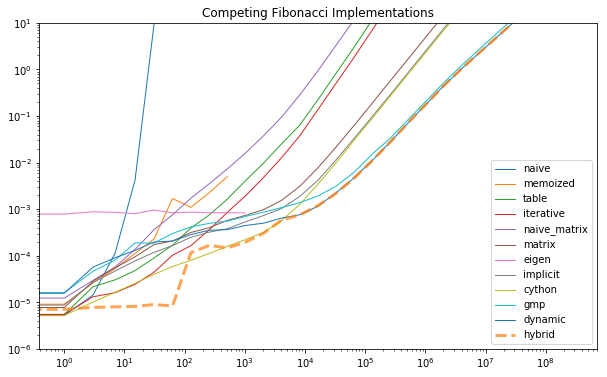

In [20]:
# plot the benchmark curves
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(10, 6))
for fib_function in implementations.keys():
    name = fib_function[:-4]
    plt.plot(
        results_df['n'], 
        results_df[fib_function], 
        label=name,
        linestyle='--' if name == 'hybrid' else '-',
        linewidth=3 if name == 'hybrid' else 1,
        alpha=0.7 if name == 'hybrid' else 1.0)
plt.xscale('log')
plt.ylim(1e-6, 10)
plt.yscale('log')
plt.legend()
plt.title("Competing Fibonacci Implementations")
plt.savefig('competing_fibonacci_implementations.png', dpi=96)
None